Andrew Dodd
, 2/21/18
# Machine Learning Project Notebook
## Table of Contents
### 1. Imports
### 2. Cleaning
### 3. Exploration/Unsupervised Learning
### 4. Modeling
### 5. Ensembling
### 6. Write to csv (results, data)

## 1. Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

house_train = pd.read_csv('./data/train.csv')
house_test = pd.read_csv('./data/test.csv')

house_train.rename(index=str, columns={"BedroomAbvGr":"Bedroom", "KitchenAbvGr":"Kitchen"},
                   inplace = True)
house_test.rename(index=str, columns={"BedroomAbvGr":"Bedroom", "KitchenAbvGr":"Kitchen"},
                    inplace = True)

names = list(house_test.columns.values)

## 2. Cleaning
Here we do the cleaning for the data. This will include examining the dataset, value imputation, visualization, filling or removing NAs, etc.

### 2.1 Converting column types to numeric
Now that we have our dataset imported, we need to convert the numeric parts into numeric.

In [4]:
with open("./data/data_description.txt") as f:
    content = f.readlines()
    
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 

import re

prev_column = '' # Most recent column name
num_lines = 0 # number of lines since column name
i = 0
for line in content:
    if (re.search('^(.{1,20}):.*', line) != None) and (num_lines == 1):
        house_train[prev_column] = pd.to_numeric(house_train[prev_column],errors = 'coerce')
        house_test[prev_column] = pd.to_numeric(house_test[prev_column],errors = 'coerce')
    if line.strip() == '':
        num_lines += 1
        next
    if (re.search('^(.{1,20}):.*', line) != None):
        prev_column = (re.search('^(.{1,20}):.*', line)).group(1)
        num_lines = 0
    i += 1

In [5]:
# Showing some interesting values...
house_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
# house_train.columns.to_series().groupby(house_train.dtypes).groups

### 2.2 Converting strings to factors and fixing values

Here we will figure out which train and test columns have values that are not a subset of the text file. In some cases, I will adjust these values.

In [7]:
prev_column = '' # Most recent column name
i = 0      # Number of loop iterations
flag = 0   # This is an indicator of whether we want to be parsing column categories
           # 0 corresponds to no, 1 corresponds to yes
           # It is set to 1 once we pass a blank row.
start = 0  # This is the number of column categories we have iterated through so far

# MAKE A DICTIONARY HERE
all_col_categ = {}
one_category_list = []
category_counter = 0
columnName = ''

# Iterating through entire list of column names and their categories.
for line in content:
    # print("-"*60)
    # print("line number:  %d" %i)
    
    # Check if it's not a new column name, flag is 1, and line is not blank
    # Let's get a list of the data
    if (re.search('^(.{1,20}):.*', line) == None) and (flag == 1) and line.strip() != '':
        # Using regex, second match is what we want:
        category = re.search('^[ |\t]*?([A-Za-z0-9_-]*)[ |\t]*(.{1,50})?',line).group(1)
        one_category_list.append(category)
        category_counter += 1
        
    # Here we check if this is the blank line after all the category names of a column.
    # It checks that our flag is 1 and that we have a blank line.
    if (flag == 1) and line.strip() == '':
        all_col_categ[columnName]=one_category_list
        #all_col_categ.append(one_category_list)
        
    # Adding to the flag
    if line.strip() == '':
        flag += 1
        
    # Reset our flag to zero when we get to a new name
    if (re.search('^(.{1,20}):.*', line) != None):
        prev_column = (re.search('^(.{1,20}):.*', line)).group(1)
        one_category_list = []   # reset our category list to null
        columnName = re.search('^(.{1,20}):.*', line).group(1)
        flag = 0             # reset our flag to 0
        category_counter = 0 # reset our category counter
        
    i += 1
#Missed last category set:
last_categories = ['Normal','Abnormal','AdjLand','Alloca','Family','Partial']
all_col_categ['SaleCondition'] = last_categories

#print(all_col_categ)

Here we will go through all of the columns. In each column, we check if it is numeric. If it is not, we will compare the category options in the text file to the categories in the dataset. If they do not match, we print the column name.

In [8]:
# Our two lists of column names are not in order together

import numbers
j = 0
for i in range(len(names)):
    name = names[i]
    
    # If the column is not numeric, we will check the categories
    if isinstance(house_train[name][0], numbers.Number) == 0:  
#         print(i)
#         print('-'*100)
#         print(name)
        all_col_set = set(all_col_categ[name])   # set of all ~42 categories from columns.txt

        # Check if sets are equal for train and test set. If they are not, print them.
        
        train_col = house_train.iloc[:, [i]]
        set_unique_train = set(pd.unique(train_col.values.ravel()))
        test_col = house_test.iloc[:, [i]]
        set_unique_test = set(pd.unique(test_col.values.ravel()))
        
#         if set_unique_train.issubset(all_col_set)==0 or set_unique_test.issubset(all_col_set)==0:
#             print(all_col_set)
#             print('.'*50)
        
#         if set_unique_train.issubset(all_col_set)==0:
#             print("The train unique values are not contained in the set from columns.txt")
#             print(set_unique_train)
#             print('.'*50)
        
#         if set_unique_test.issubset(all_col_set)==0:
#             print("The test unique values are not contained in the set from columns.txt")
#             print(set_unique_test)
            
        #CHECK TEST TOO
        
        j += 1


Fixing misnamed values

In [9]:
# MSZoning
mask = house_train.MSZoning == 'C (all)'
house_train.loc[mask, 'MSZoning'] = 'C'

# Utilities
# Interesting that the Utilities training set are all included, but test only has AllPub and nan...

# Neighborhood
mask = house_train.Neighborhood == 'NAmes'
house_train.loc[mask, 'Neighborhood'] = 'Names'
mask = house_test.Neighborhood == 'NAmes'
house_test.loc[mask, 'Neighborhood'] = 'Names'

# Building type: ignoring because the train and test match.

# House style - looks fine.
# Interestingly, 2.5 Fin is in only the training set, does not appear in test set.

# RoofMat1
# Train haas 4 more categories than test. Train has ClyTile, Metal, Membran, and Roll, which test does not have.

# Exterior1st
# Train has stone and ImStucc (test does not have these.)
# Test does not have ImStucc at all. Also has nan.
# Maybe we want to change ImStucc in to Stucc in train set?

# Exterior2nd
# nan is included in test, but not in train

# MasVnrType
# No Cblock, but we do have nans

# I did not write all the mismatched columns. The above is about half of them.
# I don't think we need to change any of the values to something else at this moment. 
# Next we'll look at nans.

### 2.3  Fixing all the NaNs

In [10]:
########################################## TRAIN #######################################
mask = house_train.Alley.isnull()
house_train.loc[mask, 'Alley'] = 'No'

mask = house_train.PoolQC.isnull()
house_train.loc[mask, 'PoolQC'] = 'No'

mask = house_train.FireplaceQu.isnull()
house_train.loc[mask, 'FireplaceQu'] = 'No'

mask = house_train.Fence.isnull()
house_train.loc[mask, 'Fence'] = 'No'

mask = house_train.MiscFeature.isnull()
house_train.loc[mask, 'MiscFeature'] = 'No'

# Garage
mask = house_train.GarageType.isnull()
house_train.loc[mask, 'GarageType'] = 'No'

mask = house_train.GarageFinish.isnull()
house_train.loc[mask, 'GarageFinish'] = 'No'

mask = house_train.GarageCond.isnull()
house_train.loc[mask, 'GarageCond'] = 'No'

mask = house_train.GarageQual.isnull()
house_train.loc[mask, 'GarageQual'] = 'No'

# Basement
mask = house_train.BsmtQual.isnull()
house_train.loc[mask, 'BsmtQual'] = 'No'

mask = house_train.BsmtCond.isnull()
house_train.loc[mask, 'BsmtCond'] = 'No'

#mask = house_train.BsmtExposure.isnull()
#house_train.loc[mask, 'BsmtExposure'] = 'No'

mask = house_train.BsmtFinType1.isnull()
house_train.loc[mask, 'BsmtFinType1'] = 'No'

mask = house_train.BsmtFinType2.isnull()
house_train.loc[mask, 'BsmtFinType2'] = 'No'

# Other
mask = house_train.MasVnrType.isnull()
house_train.loc[mask, 'MasVnrType'] = 'No'

mask = house_train.MasVnrArea.isnull()
house_train.loc[mask, 'MasVnrArea'] = 0



########################################## TEST #######################################
mask = house_test.Alley.isnull()
house_test.loc[mask, 'Alley'] = 'No'

mask = house_test.PoolQC.isnull()
house_test.loc[mask, 'PoolQC'] = 'No'

mask = house_test.FireplaceQu.isnull()
house_test.loc[mask, 'FireplaceQu'] = 'No'

mask = house_test.Fence.isnull()
house_test.loc[mask, 'Fence'] = 'No'

mask = house_test.MiscFeature.isnull()
house_test.loc[mask, 'MiscFeature'] = 'No'

# Garage
mask = house_test.GarageType.isnull()
house_test.loc[mask, 'GarageType'] = 'No'

mask = house_test.GarageFinish.isnull()
house_test.loc[mask, 'GarageFinish'] = 'No'

mask = house_test.GarageCond.isnull()
house_test.loc[mask, 'GarageCond'] = 'No'

mask = house_test.GarageQual.isnull()
house_test.loc[mask, 'GarageQual'] = 'No'

# Basement
mask = house_test.BsmtQual.isnull()
house_test.loc[mask, 'BsmtQual'] = 'No'

mask = house_test.BsmtCond.isnull()
house_test.loc[mask, 'BsmtCond'] = 'No'

#mask = house_test.BsmtExposure.isnull()
#house_test.loc[mask, 'BsmtExposure'] = 'No'

mask = house_test.BsmtFinType1.isnull()
house_test.loc[mask, 'BsmtFinType1'] = 'No'

mask = house_test.BsmtFinType2.isnull()
house_test.loc[mask, 'BsmtFinType2'] = 'No'

# Other
mask = house_test.MasVnrType.isnull()
house_test.loc[mask, 'MasVnrType'] = 'No'

mask = house_test.MasVnrArea.isnull()
house_test.loc[mask, 'MasVnrArea'] = 0

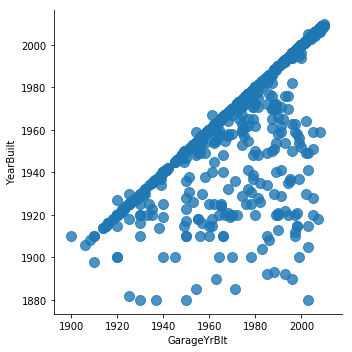

In [11]:
# Examining year built and garage, maybe we should have our GarageYrBlt nans be YearBuilt? 
# Perhaps this is not true though...
sns.lmplot('GarageYrBlt', # Horizontal axis
           'YearBuilt', # Vertical axis
           data=house_train, # Data source
           fit_reg=False, # Don't fix a regression line
           #hue="z", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

# I think it is fair to say this...it probably just means that there is no garage...
mask = house_test.GarageYrBlt.isnull()
house_test.loc[mask, 'GarageYrBlt'] = house_test.YearBuilt

mask = house_train.GarageYrBlt.isnull()
house_train.loc[mask, 'GarageYrBlt'] = house_train.YearBuilt


Filling in the last remaining NaNs with KNN:
 * Lot Frontage (~300)
 * Electrical (1)
 * 

In [12]:
# from fancyimpute import KNN 

# house_train = KNN(k=20).complete(house_train)
# house_test = KNN(k=20).complete(house_test)

# Filling in the numeric with the median value.
# here we impute the median of a bunch of 1 nans (number of basement bathrooms)
# The larger imputation here for error causing is lot frontage, with around ~300 imputations.
house_train.fillna(house_train.median(),inplace = True)
house_test.fillna(house_test.median(),inplace = True)

# Filling in the categoricals with the median value.
house_train = house_train.apply(lambda x:x.fillna(x.value_counts().index[0]))
house_test = house_test.apply(lambda x:x.fillna(x.value_counts().index[0]))

# Test
for i in range(len(names)):
    s = house_test.iloc[:,i]
    sum1 = s.isnull().sum()
    if sum1 != 0:
        print(names[i])
        print(sum1)

# Train
for i in range(len(names)):
    s = house_train.iloc[:,i]
    sum1 = s.isnull().sum()
    if sum1 != 0:
        print(names[i])
        print(sum1)
        
# Nothing printed means no more NAs! Now we can do other stuff!

### 2.3 Converting ordinal categories into numeric.

Here we will convert the following columns from categorical to numeric:
* GarageQual
* GarageCond
* FireplaceQu
* KitchenQual
* HeatingQC
* BsmtCond
* BsmtQual
* ExterCond
* ExterQual

In [13]:
train_col = house_train.iloc[:, [28]]
set_unique_train = set(pd.unique(train_col.values.ravel()))
print(set_unique_train)
print(names[28])

{'Po', 'Ex', 'TA', 'Gd', 'Fa'}
ExterCond


In [14]:
#########################################
# TRAIN
#########################################

qual_dict = {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5,
            0:0, 1:1, 2:2, 3:3, 4:4, 5:5}
house_train["ExterQual"] = house_train["ExterQual"].map(qual_dict).astype(int)
house_train["ExterCond"] = house_train["ExterCond"].map(qual_dict).astype(int)
house_train["BsmtQual"] = house_train["BsmtQual"].map(qual_dict).astype(int)
house_train["BsmtCond"] = house_train["BsmtCond"].map(qual_dict).astype(int)
house_train["HeatingQC"] = house_train["HeatingQC"].map(qual_dict).astype(int)
house_train["KitchenQual"] = house_train["KitchenQual"].map(qual_dict).astype(int)
house_train["FireplaceQu"] = house_train["FireplaceQu"].map(qual_dict).astype(int)
house_train["GarageQual"] = house_train["GarageQual"].map(qual_dict).astype(int)
house_train["GarageCond"] = house_train["GarageCond"].map(qual_dict).astype(int)

#########################################
# TEST
#########################################

qual_dict = {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5,
            0:0, 1:1, 2:2, 3:3, 4:4, 5:5}
house_test["ExterQual"] = house_test["ExterQual"].map(qual_dict).astype(int)
house_test["ExterCond"] = house_test["ExterCond"].map(qual_dict).astype(int)
house_test["BsmtQual"] = house_test["BsmtQual"].map(qual_dict).astype(int)
house_test["BsmtCond"] = house_test["BsmtCond"].map(qual_dict).astype(int)
house_test["HeatingQC"] = house_test["HeatingQC"].map(qual_dict).astype(int)
house_test["KitchenQual"] = house_test["KitchenQual"].map(qual_dict).astype(int)
house_test["FireplaceQu"] = house_test["FireplaceQu"].map(qual_dict).astype(int)
house_test["GarageQual"] = house_test["GarageQual"].map(qual_dict).astype(int)
house_test["GarageCond"] = house_test["GarageCond"].map(qual_dict).astype(int)

In [15]:
#########################################
# TRAIN
#########################################

house_train["BsmtExposure"] = house_train["BsmtExposure"].map({None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4,
                                                              0:0, 1:1, 2:2, 3:3, 4:4}).astype(int)

bsmt_fin_dict = {"No": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6,
                0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6}
house_train["BsmtFinType1"] = house_train["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
house_train["BsmtFinType2"] = house_train["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

house_train["Functional"] = house_train["Functional"].map(
        {"No": 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8, 
          0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8}).astype(int)

house_train["GarageFinish"] = house_train["GarageFinish"].map(
        {"No": 0, "Unf": 1, "RFn": 2, "Fin": 3, 0:0, 1:1, 2:2, 3:3}).astype(int)

house_train["Fence"] = house_train["Fence"].map(
        {"No": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4,
         0:0, 1:1, 2:2, 3:3, 4:4}).astype(int)

house_train["CentralAir"] = house_train["CentralAir"].map(
        {"N": 0, "Y": 1,
         0:0, 1:1}).astype(int)

#########################################
# TEST
#########################################

house_test["BsmtExposure"] = house_test["BsmtExposure"].map({None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4,
                                                              0:0, 1:1, 2:2, 3:3, 4:4}).astype(int)

bsmt_fin_dict = {"No": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6,
                0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6}
house_test["BsmtFinType1"] = house_test["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
house_test["BsmtFinType2"] = house_test["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

house_test["Functional"] = house_test["Functional"].map(
        {"No": 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8, 
          0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8}).astype(int)

house_test["GarageFinish"] = house_test["GarageFinish"].map(
        {"No": 0, "Unf": 1, "RFn": 2, "Fin": 3, 0:0, 1:1, 2:2, 3:3}).astype(int)

house_test["Fence"] = house_test["Fence"].map(
        {"No": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4,
         0:0, 1:1, 2:2, 3:3, 4:4}).astype(int)

house_test["CentralAir"] = house_test["CentralAir"].map(
        {"N": 0, "Y": 1,
         0:0, 1:1}).astype(int)

In [16]:
x = house_train.columns.to_series().groupby(house_train.dtypes).groups
# print(x)

### 2.4 Non-ordinal Categorical Variables and Feature Engineering

In [17]:
#########################################
# TRAIN
#########################################

# IR2 and IR3 don't appear that often, so just make a distinction
# between regular and irregular.
house_train["IsRegularLotShape"] = (house_train["LotShape"] == "Reg") * 1

# Most properties are level; bin the other possibilities together
# as "not level".
house_train["IsLandLevel"] = (house_train["LandContour"] == "Lvl") * 1

# Most land slopes are gentle; treat the others as "not gentle".
house_train["IsLandSlopeGentle"] = (house_train["LandSlope"] == "Gtl") * 1

# Most properties use standard circuit breakers.
house_train["IsElectricalSBrkr"] = (house_train["Electrical"] == "SBrkr") * 1

# About 2/3rd have an attached garage.
house_train["IsGarageDetached"] = (house_train["GarageType"] == "Detchd") * 1

# Most have a paved drive. Treat dirt/gravel and partial pavement
# as "not paved".
house_train["IsPavedDrive"] = (house_train["PavedDrive"] == "Y") * 1

# The only interesting "misc. feature" is the presence of a shed.
house_train["HasShed"] = (house_train["MiscFeature"] == "Shed") * 1.  

# If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
house_train["Remodeled"] = (house_train["YearRemodAdd"] != house_train["YearBuilt"]) * 1
    
# Did a remodeling happen in the year the house was sold?
house_train["RecentRemodel"] = (house_train["YearRemodAdd"] == house_train["YrSold"]) * 1
    
# Was this house sold in the year it was built?
house_train["VeryNewHouse"] = (house_train["YearBuilt"] == house_train["YrSold"]) * 1

#########################################
# TEST
#########################################

# IR2 and IR3 don't appear that often, so just make a distinction
# between regular and irregular.
house_test["IsRegularLotShape"] = (house_test["LotShape"] == "Reg") * 1

# Most properties are level; bin the other possibilities together
# as "not level".
house_test["IsLandLevel"] = (house_test["LandContour"] == "Lvl") * 1

# Most land slopes are gentle; treat the others as "not gentle".
house_test["IsLandSlopeGentle"] = (house_test["LandSlope"] == "Gtl") * 1

# Most properties use standard circuit breakers.
house_test["IsElectricalSBrkr"] = (house_test["Electrical"] == "SBrkr") * 1

# About 2/3rd have an attached garage.
house_test["IsGarageDetached"] = (house_test["GarageType"] == "Detchd") * 1

# Most have a paved drive. Treat dirt/gravel and partial pavement
# as "not paved".
house_test["IsPavedDrive"] = (house_test["PavedDrive"] == "Y") * 1

# The only interesting "misc. feature" is the presence of a shed.
house_test["HasShed"] = (house_test["MiscFeature"] == "Shed") * 1.  

# If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
house_test["Remodeled"] = (house_test["YearRemodAdd"] != house_test["YearBuilt"]) * 1
    
# Did a remodeling happen in the year the house was sold?
house_test["RecentRemodel"] = (house_test["YearRemodAdd"] == house_test["YrSold"]) * 1
    
# Was this house sold in the year it was built?
house_test["VeryNewHouse"] = (house_test["YearBuilt"] == house_test["YrSold"]) * 1

More feature engineering, a lot of it coming from:
https://www.kaggle.com/humananalog/xgboost-lasso/code

In [18]:
# More feature engineering...

#########################################
# TRAIN
#########################################

house_train["Has2ndFloor"] = (house_train["2ndFlrSF"] == 0) * 1
house_train["HasMasVnr"] = (house_train["MasVnrArea"] == 0) * 1
house_train["HasWoodDeck"] = (house_train["WoodDeckSF"] == 0) * 1
house_train["HasOpenPorch"] = (house_train["OpenPorchSF"] == 0) * 1
house_train["HasEnclosedPorch"] = (house_train["EnclosedPorch"] == 0) * 1
house_train["Has3SsnPorch"] = (house_train["3SsnPorch"] == 0) * 1
house_train["HasScreenPorch"] = (house_train["ScreenPorch"] == 0) * 1

# Months with the largest number of deals may be significant.
house_train["HighSeason"] = house_train["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

house_train["NewerDwelling"] = house_train["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
house_train.loc[house_train.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
house_train.loc[house_train.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
house_train.loc[house_train.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
house_train.loc[house_train.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
house_train.loc[house_train.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
house_train["Neighborhood_Good"].fillna(0, inplace=True)

house_train["SaleCondition_PriceDown"] = house_train.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# House completed before sale or not
house_train["BoughtOffPlan"] = house_train.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
house_train["BadHeating"] = house_train.HeatingQC.replace(
        {5: 0, 4: 0, 3: 0, 2: 1, 1: 1, 0:0})

area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
house_train["TotalArea"] = house_train[area_cols].sum(axis=1)

house_train["TotalArea1st2nd"] = house_train["1stFlrSF"] + house_train["2ndFlrSF"]

house_train["Age"] = 2010 - house_train["YearBuilt"]
house_train["TimeSinceSold"] = 2010 - house_train["YrSold"]

house_train["SeasonSold"] = house_train["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
house_train["YearsSinceRemodel"] = house_train["YrSold"] - house_train["YearRemodAdd"]

#########################################
# TEST
#########################################

house_test["Has2ndFloor"] = (house_test["2ndFlrSF"] == 0) * 1
house_test["HasMasVnr"] = (house_test["MasVnrArea"] == 0) * 1
house_test["HasWoodDeck"] = (house_test["WoodDeckSF"] == 0) * 1
house_test["HasOpenPorch"] = (house_test["OpenPorchSF"] == 0) * 1
house_test["HasEnclosedPorch"] = (house_test["EnclosedPorch"] == 0) * 1
house_test["Has3SsnPorch"] = (house_test["3SsnPorch"] == 0) * 1
house_test["HasScreenPorch"] = (house_test["ScreenPorch"] == 0) * 1

# Months with the largest number of deals may be significant.
house_test["HighSeason"] = house_test["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

house_test["NewerDwelling"] = house_test["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
house_test.loc[house_test.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
house_test.loc[house_test.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
house_test.loc[house_test.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
house_test.loc[house_test.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
house_test.loc[house_test.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
house_test["Neighborhood_Good"].fillna(0, inplace=True)

house_test["SaleCondition_PriceDown"] = house_test.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# House completed before sale or not
house_test["BoughtOffPlan"] = house_test.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
house_test["BadHeating"] = house_test.HeatingQC.replace(
        {5: 0, 4: 0, 3: 0, 2: 1, 1: 1, 0:0})

area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
house_test["TotalArea"] = house_test[area_cols].sum(axis=1)

house_test["TotalArea1st2nd"] = house_test["1stFlrSF"] + house_test["2ndFlrSF"]

house_test["Age"] = 2010 - house_test["YearBuilt"]
house_test["TimeSinceSold"] = 2010 - house_test["YrSold"]

house_test["SeasonSold"] = house_test["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
house_test["YearsSinceRemodel"] = house_test["YrSold"] - house_test["YearRemodAdd"]

Now we add in some neighborhood information:

In [19]:

    
# Bin by neighborhood (a little arbitrarily). Values were computed by: 
# train_df["SalePrice"].groupby(train_df["Neighborhood"]).median().sort_values()
neighborhood_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "Names" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
}

house_train["NeighborhoodBin"] = house_train["Neighborhood"].map(neighborhood_map)
house_test["NeighborhoodBin"] = house_test["Neighborhood"].map(neighborhood_map)

Let's see if the USA market housing fluxuations affected this small town. We can put all the points on a plot...

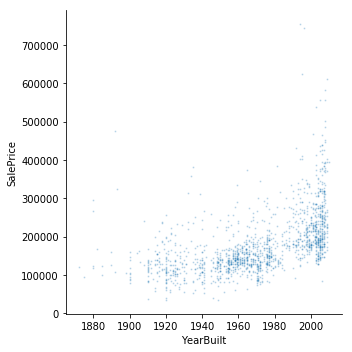

In [20]:
sns.lmplot('YearBuilt', # Horizontal axis
           'SalePrice', # Vertical axis
           data=house_train, # Data source
           fit_reg=False, # Don't fix a regression line
           scatter_kws={"marker": "D", # Set marker style
                        "alpha": .2,
                        "s": 1}) # S marker size

# There is a definite trend here in price, but this might be learned from the year columns...

In [21]:
# house_train.columns.to_series().groupby(house_train.dtypes).groups

Now we have done some good feature engineering. For the rest of the categorical features that are left, we can either omit them or use them as one hot features (get_dummies). We'll see what's best in the future.

### 2.5 Removing Outliers

In order to refine our algorithm we are going to want to remove outliers, points that are too far beyond the realm of likelihood...

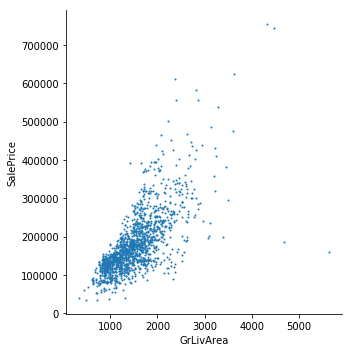

In [22]:
sns.lmplot('GrLivArea', # Horizontal axis
           'SalePrice', # Vertical axis
           data=house_train, # Data source
           fit_reg=False, # Don't fix a regression line
           scatter_kws={"marker": "D", # Set marker style
                        "alpha": 1,
                        "s": 1}) # S marker size

In [23]:
# Based on the author's paper, we will remove some of the outliers:
house_train = house_train.drop(house_train[(house_train.GrLivArea > 4000) & (house_train['SalePrice']<300000)].index)

### 2.6 Take log of SalePrice

In [24]:
cols = house_train.columns.tolist()
# print(cols[0])
# print(cols.index('SalePrice'))
# print(len(cols[0:80]))
# print(len(cols[81:91]))
cols = cols[1:80] + cols[81:111] + [cols[80]]
house_train_d = house_train[cols] 
house_train_d.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,BoughtOffPlan,BadHeating,TotalArea,TotalArea1st2nd,Age,TimeSinceSold,SeasonSold,YearsSinceRemodel,NeighborhoodBin,SalePrice
0,60,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,Inside,...,0,0,14452.0,1710,7,2,0,5,2,208500
1,20,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,FR2,...,0,0,15486.0,1262,34,3,1,31,3,181500
2,60,RL,68.0,11250,Pave,No,IR1,Lvl,AllPub,Inside,...,0,0,17542.0,1786,9,2,3,6,2,223500
3,70,RL,60.0,9550,Pave,No,IR1,Lvl,AllPub,Corner,...,0,0,15505.0,1717,95,4,0,36,3,140000
4,60,RL,84.0,14260,Pave,No,IR1,Lvl,AllPub,FR2,...,0,0,22492.0,2198,10,2,0,8,4,250000


In [25]:
house_train_d.shape

(1458, 110)

In [26]:
house_test = house_test.iloc[:,1:]
house_test.shape

(1459, 109)

In [27]:
house_test_log = house_test.copy()
house_train_log = house_train_d.drop(['SalePrice'], axis =1)
print(house_test_log.shape)
print(house_train_log.shape)

(1459, 109)
(1458, 109)


In [28]:
house_train_test_log = pd.concat((house_train_log, house_test_log), axis =0)

In [29]:
house_train_test_log.shape

(2917, 109)

In [30]:
house_train_d["SalePrice"] = np.log1p(house_train_d["SalePrice"])

/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
#house_train_d["SalePrice"]

### 2.7 Take log of skewed predictors' values

In [32]:
from scipy.stats import norm, skew
numeric_feats = house_train_test_log.dtypes[house_train_test_log.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = house_train_test_log[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
TotalArea,10.572503
HasShed,5.266776
BadHeating,5.266776
VeryNewHouse,4.756931
Kitchen,4.300550


In [33]:
skewness = skewness[abs(skewness) > 0.75]
skewed_features = skewness.index
house_train_test_log[skewed_features] = np.log1p(house_train_test_log[skewed_features])

/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
house_train_1 = house_train_test_log.iloc[0:1458,]
house_test_1 = house_train_test_log.iloc[1458:,]
print(house_test_1.shape)
print(house_train_1.shape)

(1459, 109)
(1458, 109)


In [35]:
house_train_1 = house_train_1.loc[:, house_train_1.dtypes != 'object']
house_test_1 = house_test_1.loc[:, house_test_1.dtypes != 'object']
print(house_test_1.shape)
print(house_train_1.shape)

(1459, 82)
(1458, 82)


In [36]:
X1 = house_train_1.values
y1 = house_train_d['SalePrice'].values

## 3. Models

### 3.1 Split training data into 80/20

In [41]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

### 3.2 OLS

In [42]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X1_train, y1_train)
y_pred_ols = ols.predict(X1_test)

# log_error = rmsle(y1_test, y_pred_ols)
# print(log_error)

In [43]:
ols.score(X1_test, y1_test)

0.92419304962502191

In [44]:
np.square(y_pred_ols - y1_test).mean() ** 0.5

0.11304535581571921

### 3.3 Lasso

In [445]:
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge
regr = Lasso(alpha=.0005, max_iter=50000, tol = .0001)
regr.fit(X1_train, y1_train)

# # Run prediction on training set to get a rough idea of how well it does.
y_pred_lasso = regr.predict(X1_test)
# np.square(y_pred_lasso - y1_test).mean() ** 0.5
# # log_error = rmsle(y_test, y_pred)
# # print(log_error)

In [447]:
regr.score(X1_test, y1_test)

0.92162697827382289

In [209]:
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge
regr = Lasso(alpha=.0005, max_iter=50000, tol = .0001)
regr.fit(X1_train, y1_train)

# Run prediction on training set to get a rough idea of how well it does.
y_pred_lasso = regr.predict(X1_test)
np.square(y_pred_lasso - y1_test).mean() ** 0.5
# log_error = rmsle(y_test, y_pred)
# print(log_error)

0.11494273005621622

In [280]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X1_train, y1_train)
print(model_lasso.alpha_)
rmse_cv(model_lasso).mean()

0.0005


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.120119049370396

In [250]:
model_lasso = Lasso()
alphas = [1, 0.1, 0.001, 0.0005]
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

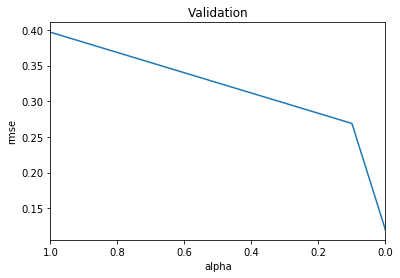

In [251]:
from matplotlib import pyplot as plt
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

### 3.4 Ridge

In [285]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X1_train, y1_train, scoring="mean_squared_error", cv = 10))
    return(rmse)

In [286]:
model_ridge = Ridge()
alphas = [0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10]
# alphas = [1, 3, 5, 10, 20, 30, 50, 100]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

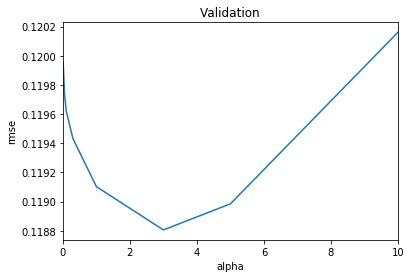

In [287]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [288]:
cv_ridge.min()

0.11880610827532898

In [290]:
ridgecv = RidgeCV(alphas=np.arange(0.1, 10, 0.1), fit_intercept=True, normalize=False, 
        scoring="neg_mean_squared_error", cv=10, gcv_mode=None, store_cv_values=False).fit(X1_train, y1_train)
print(ridgecv.alpha_)

3.1


### 3.5 Elastic Net

In [77]:
from math import sqrt

In [309]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
elasticnet = ElasticNetCV(l1_ratio = np.arange(0.1,1,0.1), eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute='auto', 
             max_iter=1000, tol=0.0001, cv=10, copy_X=True).fit(X1_train, y1_train)

In [303]:
elasticnet.alpha_

0.0014691120104383165

In [304]:
elasticnet.l1_ratio_

0.30000000000000004

In [ ]:
score = []

In [363]:
param_grid = {
                 'alpha': [0.0003],
                 'l1_ratio': np.arange(0, 1, 0.1)
             }
clf = ElasticNet()

In [364]:
from sklearn.model_selection import GridSearchCV
grid_clf = GridSearchCV(clf, param_grid, cv=10, scoring = 'neg_mean_squared_error', verbose = 2)
grid_clf.fit(X1_train, y1_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] alpha=0.0003, l1_ratio=0.0 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.0, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.0 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.0, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.0 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.0, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.0 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.0, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.0 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.0, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.0 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.0, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.0 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.0, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.0 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.0, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.0 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.0, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.0 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.0, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.1 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.1, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.1 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: 

[CV] ....................... alpha=0.0003, l1_ratio=0.1, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.1 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.1, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.1 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.1, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.1 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: 

[CV] ....................... alpha=0.0003, l1_ratio=0.1, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.1 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.1, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.1 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.1, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.1 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.1, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.1 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.1, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.1 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.1, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.2 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.2, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.2 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.2, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.2 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.2, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.2 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.2, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.2 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.2, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.2 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.2, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.2 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.2, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.2 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.2, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.2 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.2, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.2 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: 

[CV] ....................... alpha=0.0003, l1_ratio=0.2, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.3 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.3 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.3 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.3, total=   0.1s

/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



[CV] alpha=0.0003, l1_ratio=0.3 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.3 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.3 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.3 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.3 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.3 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.3 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.3, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.4 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.4, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.4 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: 

[CV] ....................... alpha=0.0003, l1_ratio=0.4, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.4 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.4, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.4 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.4, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.4 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.4, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.4 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.4, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.4 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.4, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.4 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.4, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.4 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.4, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.4 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.4, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.5 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.5, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.5 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.5, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.5 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: 

[CV] ....................... alpha=0.0003, l1_ratio=0.5, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.5 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.5, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.5 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.5, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.5 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.5, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.5 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: 

[CV] ....................... alpha=0.0003, l1_ratio=0.5, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.5 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.5, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.5 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.5, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.5 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.5, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.6 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.6, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.6 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.6, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.6 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.6, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.6 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: 

[CV] ....................... alpha=0.0003, l1_ratio=0.6, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.6 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.6, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.6 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.6, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.6 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.6, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.6 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.6, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.6 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.6, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.6 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.6, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.7 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.7, total=   0.0s
[CV] alpha=0.0003, l1_ratio=0.7 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: 

[CV] ....................... alpha=0.0003, l1_ratio=0.7, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.7 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.7, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.7 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.7, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.7 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.7, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.7 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.7, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.7 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.7, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.7 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.7, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.7 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.7, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.7 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.7, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.0003, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.8, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.8 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.8, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.8, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.8, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.8, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.8 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.0003, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.8, total=   0.0s
[CV] alpha=0.0003, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.8, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.8 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.8, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.9 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.9, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.9 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.9, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.9 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.9, total=   0.0s
[CV] alpha=0.0003, l1_ratio=0.9 ......................................
[CV] .

/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....................... alpha=0.0003, l1_ratio=0.9, total=   0.0s
[CV] alpha=0.0003, l1_ratio=0.9 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.9, total=   0.1s
[CV] alpha=0.0003, l1_ratio=0.9 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.9, total=   0.0s
[CV] alpha=0.0003, l1_ratio=0.9 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.9, total=   0.0s
[CV] alpha=0.0003, l1_ratio=0.9 ......................................
[CV] ....................... alpha=0.0003, l1_ratio=0.9, total=   0.0s
[CV] alpha=0.0003, l1_ratio=0.9 ......................................


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.4s finished


[CV] ....................... alpha=0.0003, l1_ratio=0.9, total=   0.1s


/Users/peter/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=10, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0003], 'l1_ratio': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [365]:
grid_clf.best_params_

{'alpha': 0.0003, 'l1_ratio': 0.40000000000000002}

In [366]:
score.append(sqrt(-grid_clf.best_score_))

In [367]:
sqrt(-grid_clf.best_score_)

0.12005131023966066

In [ ]:
 #ran = grid_clf.best_estimator_

In [368]:
score

[0.12005347347150115, 0.12005131023966066]

### 3.6 SVR

In [391]:
svr_score = []

In [455]:
from sklearn.svm import SVR
clf = SVR(C=10, epsilon=0.1, kernel = 'linear')
clf.fit(X1_train, y1_train)
clf.score(X1_test, y1_test)

0.92122192198544717

In [441]:
y_pred_2 = clf.predict(X1_test)
score = np.square(y_pred_2 - y1_test).mean() ** 0.5

In [442]:
svr_score.append(score)

In [443]:
svr_score

[0.13505024331881751,
 0.16874057074938953,
 0.14829758887759578,
 0.17553979496685862,
 0.13245711571345223,
 0.14829758887759578,
 0.14829758887759578,
 0.11523937724813439,
 0.11527469571639182,
 0.11435409576959087,
 0.11492172377520793,
 0.11510948280387304,
 0.11435409576959087]

In [456]:
# from sklearn.model_selection import GridSearchCV
# grid_clf = GridSearchCV(clf, param_grid, cv=10, scoring = 'neg_mean_squared_error', verbose = 2)
# grid_clf.fit(X1_train, y1_train)

### 3.7 Random Forest

In [464]:
random_score = []

In [493]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=1000, max_depth=100, random_state=0, verbose = 2)
regr.fit(X1_train, y1_train)
regr.score(X1_test, y1_test)

building tree 1 of 3000
building tree 2 of 3000
building tree 3 of 3000
building tree 4 of 3000
building tree 5 of 3000
building tree 6 of 3000
building tree 7 of 3000
building tree 8 of 3000
building tree 9 of 3000
building tree 10 of 3000
building tree 11 of 3000
building tree 12 of 3000
building tree 13 of 3000


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 14 of 3000
building tree 15 of 3000
building tree 16 of 3000
building tree 17 of 3000
building tree 18 of 3000
building tree 19 of 3000
building tree 20 of 3000
building tree 21 of 3000
building tree 22 of 3000
building tree 23 of 3000
building tree 24 of 3000
building tree 25 of 3000
building tree 26 of 3000
building tree 27 of 3000
building tree 28 of 3000
building tree 29 of 3000
building tree 30 of 3000
building tree 31 of 3000
building tree 32 of 3000
building tree 33 of 3000
building tree 34 of 3000
building tree 35 of 3000
building tree 36 of 3000
building tree 37 of 3000
building tree 38 of 3000
building tree 39 of 3000
building tree 40 of 3000
building tree 41 of 3000
building tree 42 of 3000
building tree 43 of 3000
building tree 44 of 3000
building tree 45 of 3000
building tree 46 of 3000
building tree 47 of 3000
building tree 48 of 3000
building tree 49 of 3000
building tree 50 of 3000
building tree 51 of 3000
building tree 52 of 3000
building tree 53 of 3000


building tree 341 of 3000
building tree 342 of 3000
building tree 343 of 3000
building tree 344 of 3000
building tree 345 of 3000
building tree 346 of 3000
building tree 347 of 3000
building tree 348 of 3000
building tree 349 of 3000
building tree 350 of 3000
building tree 351 of 3000
building tree 352 of 3000
building tree 353 of 3000
building tree 354 of 3000
building tree 355 of 3000
building tree 356 of 3000
building tree 357 of 3000
building tree 358 of 3000
building tree 359 of 3000
building tree 360 of 3000
building tree 361 of 3000
building tree 362 of 3000
building tree 363 of 3000
building tree 364 of 3000
building tree 365 of 3000
building tree 366 of 3000
building tree 367 of 3000
building tree 368 of 3000
building tree 369 of 3000
building tree 370 of 3000
building tree 371 of 3000
building tree 372 of 3000
building tree 373 of 3000
building tree 374 of 3000
building tree 375 of 3000
building tree 376 of 3000
building tree 377 of 3000
building tree 378 of 3000
building tre

building tree 660 of 3000
building tree 661 of 3000
building tree 662 of 3000
building tree 663 of 3000
building tree 664 of 3000
building tree 665 of 3000
building tree 666 of 3000
building tree 667 of 3000
building tree 668 of 3000
building tree 669 of 3000
building tree 670 of 3000
building tree 671 of 3000
building tree 672 of 3000
building tree 673 of 3000
building tree 674 of 3000
building tree 675 of 3000
building tree 676 of 3000
building tree 677 of 3000
building tree 678 of 3000
building tree 679 of 3000
building tree 680 of 3000
building tree 681 of 3000
building tree 682 of 3000
building tree 683 of 3000
building tree 684 of 3000
building tree 685 of 3000
building tree 686 of 3000
building tree 687 of 3000
building tree 688 of 3000
building tree 689 of 3000
building tree 690 of 3000
building tree 691 of 3000
building tree 692 of 3000
building tree 693 of 3000
building tree 694 of 3000
building tree 695 of 3000
building tree 696 of 3000
building tree 697 of 3000
building tre

building tree 976 of 3000
building tree 977 of 3000
building tree 978 of 3000
building tree 979 of 3000
building tree 980 of 3000
building tree 981 of 3000
building tree 982 of 3000
building tree 983 of 3000
building tree 984 of 3000
building tree 985 of 3000
building tree 986 of 3000
building tree 987 of 3000
building tree 988 of 3000
building tree 989 of 3000
building tree 990 of 3000
building tree 991 of 3000
building tree 992 of 3000
building tree 993 of 3000
building tree 994 of 3000
building tree 995 of 3000
building tree 996 of 3000
building tree 997 of 3000
building tree 998 of 3000
building tree 999 of 3000
building tree 1000 of 3000
building tree 1001 of 3000
building tree 1002 of 3000
building tree 1003 of 3000
building tree 1004 of 3000
building tree 1005 of 3000
building tree 1006 of 3000
building tree 1007 of 3000
building tree 1008 of 3000
building tree 1009 of 3000
building tree 1010 of 3000
building tree 1011 of 3000
building tree 1012 of 3000
building tree 1013 of 300

building tree 1584 of 3000
building tree 1585 of 3000
building tree 1586 of 3000
building tree 1587 of 3000
building tree 1588 of 3000
building tree 1589 of 3000
building tree 1590 of 3000
building tree 1591 of 3000
building tree 1592 of 3000
building tree 1593 of 3000
building tree 1594 of 3000
building tree 1595 of 3000
building tree 1596 of 3000
building tree 1597 of 3000
building tree 1598 of 3000
building tree 1599 of 3000
building tree 1600 of 3000
building tree 1601 of 3000
building tree 1602 of 3000
building tree 1603 of 3000
building tree 1604 of 3000
building tree 1605 of 3000
building tree 1606 of 3000
building tree 1607 of 3000
building tree 1608 of 3000
building tree 1609 of 3000
building tree 1610 of 3000
building tree 1611 of 3000
building tree 1612 of 3000
building tree 1613 of 3000
building tree 1614 of 3000
building tree 1615 of 3000
building tree 1616 of 3000
building tree 1617 of 3000
building tree 1618 of 3000
building tree 1619 of 3000
building tree 1620 of 3000
b

building tree 1898 of 3000
building tree 1899 of 3000
building tree 1900 of 3000
building tree 1901 of 3000
building tree 1902 of 3000
building tree 1903 of 3000
building tree 1904 of 3000
building tree 1905 of 3000
building tree 1906 of 3000
building tree 1907 of 3000
building tree 1908 of 3000
building tree 1909 of 3000
building tree 1910 of 3000
building tree 1911 of 3000
building tree 1912 of 3000
building tree 1913 of 3000
building tree 1914 of 3000
building tree 1915 of 3000
building tree 1916 of 3000
building tree 1917 of 3000
building tree 1918 of 3000
building tree 1919 of 3000
building tree 1920 of 3000
building tree 1921 of 3000
building tree 1922 of 3000
building tree 1923 of 3000
building tree 1924 of 3000
building tree 1925 of 3000
building tree 1926 of 3000
building tree 1927 of 3000
building tree 1928 of 3000
building tree 1929 of 3000
building tree 1930 of 3000
building tree 1931 of 3000
building tree 1932 of 3000
building tree 1933 of 3000
building tree 1934 of 3000
b

building tree 2204 of 3000
building tree 2205 of 3000
building tree 2206 of 3000
building tree 2207 of 3000
building tree 2208 of 3000
building tree 2209 of 3000
building tree 2210 of 3000
building tree 2211 of 3000
building tree 2212 of 3000
building tree 2213 of 3000
building tree 2214 of 3000
building tree 2215 of 3000
building tree 2216 of 3000
building tree 2217 of 3000
building tree 2218 of 3000
building tree 2219 of 3000
building tree 2220 of 3000
building tree 2221 of 3000
building tree 2222 of 3000
building tree 2223 of 3000
building tree 2224 of 3000
building tree 2225 of 3000
building tree 2226 of 3000
building tree 2227 of 3000
building tree 2228 of 3000
building tree 2229 of 3000
building tree 2230 of 3000
building tree 2231 of 3000
building tree 2232 of 3000
building tree 2233 of 3000
building tree 2234 of 3000
building tree 2235 of 3000
building tree 2236 of 3000
building tree 2237 of 3000
building tree 2238 of 3000
building tree 2239 of 3000
building tree 2240 of 3000
b

building tree 2515 of 3000
building tree 2516 of 3000
building tree 2517 of 3000
building tree 2518 of 3000
building tree 2519 of 3000
building tree 2520 of 3000
building tree 2521 of 3000
building tree 2522 of 3000
building tree 2523 of 3000
building tree 2524 of 3000
building tree 2525 of 3000
building tree 2526 of 3000
building tree 2527 of 3000
building tree 2528 of 3000
building tree 2529 of 3000
building tree 2530 of 3000
building tree 2531 of 3000
building tree 2532 of 3000
building tree 2533 of 3000
building tree 2534 of 3000
building tree 2535 of 3000
building tree 2536 of 3000
building tree 2537 of 3000
building tree 2538 of 3000
building tree 2539 of 3000
building tree 2540 of 3000
building tree 2541 of 3000
building tree 2542 of 3000
building tree 2543 of 3000
building tree 2544 of 3000
building tree 2545 of 3000
building tree 2546 of 3000
building tree 2547 of 3000
building tree 2548 of 3000
building tree 2549 of 3000
building tree 2550 of 3000
building tree 2551 of 3000
b

building tree 2826 of 3000
building tree 2827 of 3000
building tree 2828 of 3000
building tree 2829 of 3000
building tree 2830 of 3000
building tree 2831 of 3000
building tree 2832 of 3000
building tree 2833 of 3000
building tree 2834 of 3000
building tree 2835 of 3000
building tree 2836 of 3000
building tree 2837 of 3000
building tree 2838 of 3000
building tree 2839 of 3000
building tree 2840 of 3000
building tree 2841 of 3000
building tree 2842 of 3000
building tree 2843 of 3000
building tree 2844 of 3000
building tree 2845 of 3000
building tree 2846 of 3000
building tree 2847 of 3000
building tree 2848 of 3000
building tree 2849 of 3000
building tree 2850 of 3000
building tree 2851 of 3000
building tree 2852 of 3000
building tree 2853 of 3000
building tree 2854 of 3000
building tree 2855 of 3000
building tree 2856 of 3000
building tree 2857 of 3000
building tree 2858 of 3000
building tree 2859 of 3000
building tree 2860 of 3000
building tree 2861 of 3000
building tree 2862 of 3000
b

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:   48.2s finished


building tree 1 of 3000
building tree 2 of 3000
building tree 3 of 3000
building tree 4 of 3000
building tree 5 of 3000
building tree 6 of 3000
building tree 7 of 3000
building tree 8 of 3000
building tree 9 of 3000
building tree 10 of 3000
building tree 11 of 3000
building tree 12 of 3000


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 13 of 3000
building tree 14 of 3000
building tree 15 of 3000
building tree 16 of 3000
building tree 17 of 3000
building tree 18 of 3000
building tree 19 of 3000
building tree 20 of 3000
building tree 21 of 3000
building tree 22 of 3000
building tree 23 of 3000
building tree 24 of 3000
building tree 25 of 3000
building tree 26 of 3000
building tree 27 of 3000
building tree 28 of 3000
building tree 29 of 3000
building tree 30 of 3000
building tree 31 of 3000
building tree 32 of 3000
building tree 33 of 3000
building tree 34 of 3000
building tree 35 of 3000
building tree 36 of 3000
building tree 37 of 3000
building tree 38 of 3000
building tree 39 of 3000
building tree 40 of 3000
building tree 41 of 3000
building tree 42 of 3000
building tree 43 of 3000
building tree 44 of 3000
building tree 45 of 3000
building tree 46 of 3000
building tree 47 of 3000
building tree 48 of 3000
building tree 49 of 3000
building tree 50 of 3000
building tree 51 of 3000
building tree 52 of 3000


building tree 334 of 3000
building tree 335 of 3000
building tree 336 of 3000
building tree 337 of 3000
building tree 338 of 3000
building tree 339 of 3000
building tree 340 of 3000
building tree 341 of 3000
building tree 342 of 3000
building tree 343 of 3000
building tree 344 of 3000
building tree 345 of 3000
building tree 346 of 3000
building tree 347 of 3000
building tree 348 of 3000
building tree 349 of 3000
building tree 350 of 3000
building tree 351 of 3000
building tree 352 of 3000
building tree 353 of 3000
building tree 354 of 3000
building tree 355 of 3000
building tree 356 of 3000
building tree 357 of 3000
building tree 358 of 3000
building tree 359 of 3000
building tree 360 of 3000
building tree 361 of 3000
building tree 362 of 3000
building tree 363 of 3000
building tree 364 of 3000
building tree 365 of 3000
building tree 366 of 3000
building tree 367 of 3000
building tree 368 of 3000
building tree 369 of 3000
building tree 370 of 3000
building tree 371 of 3000
building tre

building tree 650 of 3000
building tree 651 of 3000
building tree 652 of 3000
building tree 653 of 3000
building tree 654 of 3000
building tree 655 of 3000
building tree 656 of 3000
building tree 657 of 3000
building tree 658 of 3000
building tree 659 of 3000
building tree 660 of 3000
building tree 661 of 3000
building tree 662 of 3000
building tree 663 of 3000
building tree 664 of 3000
building tree 665 of 3000
building tree 666 of 3000
building tree 667 of 3000
building tree 668 of 3000
building tree 669 of 3000
building tree 670 of 3000
building tree 671 of 3000
building tree 672 of 3000
building tree 673 of 3000
building tree 674 of 3000
building tree 675 of 3000
building tree 676 of 3000
building tree 677 of 3000
building tree 678 of 3000
building tree 679 of 3000
building tree 680 of 3000
building tree 681 of 3000
building tree 682 of 3000
building tree 683 of 3000
building tree 684 of 3000
building tree 685 of 3000
building tree 686 of 3000
building tree 687 of 3000
building tre

building tree 969 of 3000
building tree 970 of 3000
building tree 971 of 3000
building tree 972 of 3000
building tree 973 of 3000
building tree 974 of 3000
building tree 975 of 3000
building tree 976 of 3000
building tree 977 of 3000
building tree 978 of 3000
building tree 979 of 3000
building tree 980 of 3000
building tree 981 of 3000
building tree 982 of 3000
building tree 983 of 3000
building tree 984 of 3000
building tree 985 of 3000
building tree 986 of 3000
building tree 987 of 3000
building tree 988 of 3000
building tree 989 of 3000
building tree 990 of 3000
building tree 991 of 3000
building tree 992 of 3000
building tree 993 of 3000
building tree 994 of 3000
building tree 995 of 3000
building tree 996 of 3000
building tree 997 of 3000
building tree 998 of 3000
building tree 999 of 3000
building tree 1000 of 3000
building tree 1001 of 3000
building tree 1002 of 3000
building tree 1003 of 3000
building tree 1004 of 3000
building tree 1005 of 3000
building tree 1006 of 3000
build

building tree 1286 of 3000
building tree 1287 of 3000
building tree 1288 of 3000
building tree 1289 of 3000
building tree 1290 of 3000
building tree 1291 of 3000
building tree 1292 of 3000
building tree 1293 of 3000
building tree 1294 of 3000
building tree 1295 of 3000
building tree 1296 of 3000
building tree 1297 of 3000
building tree 1298 of 3000
building tree 1299 of 3000
building tree 1300 of 3000
building tree 1301 of 3000
building tree 1302 of 3000
building tree 1303 of 3000
building tree 1304 of 3000
building tree 1305 of 3000
building tree 1306 of 3000
building tree 1307 of 3000
building tree 1308 of 3000
building tree 1309 of 3000
building tree 1310 of 3000
building tree 1311 of 3000
building tree 1312 of 3000
building tree 1313 of 3000
building tree 1314 of 3000
building tree 1315 of 3000
building tree 1316 of 3000
building tree 1317 of 3000
building tree 1318 of 3000
building tree 1319 of 3000
building tree 1320 of 3000
building tree 1321 of 3000
building tree 1322 of 3000
b

building tree 1601 of 3000
building tree 1602 of 3000
building tree 1603 of 3000
building tree 1604 of 3000
building tree 1605 of 3000
building tree 1606 of 3000
building tree 1607 of 3000
building tree 1608 of 3000
building tree 1609 of 3000
building tree 1610 of 3000
building tree 1611 of 3000
building tree 1612 of 3000
building tree 1613 of 3000
building tree 1614 of 3000
building tree 1615 of 3000
building tree 1616 of 3000
building tree 1617 of 3000
building tree 1618 of 3000
building tree 1619 of 3000
building tree 1620 of 3000
building tree 1621 of 3000
building tree 1622 of 3000
building tree 1623 of 3000
building tree 1624 of 3000
building tree 1625 of 3000
building tree 1626 of 3000
building tree 1627 of 3000
building tree 1628 of 3000
building tree 1629 of 3000
building tree 1630 of 3000
building tree 1631 of 3000
building tree 1632 of 3000
building tree 1633 of 3000
building tree 1634 of 3000
building tree 1635 of 3000
building tree 1636 of 3000
building tree 1637 of 3000
b

building tree 1906 of 3000
building tree 1907 of 3000
building tree 1908 of 3000
building tree 1909 of 3000
building tree 1910 of 3000
building tree 1911 of 3000
building tree 1912 of 3000
building tree 1913 of 3000
building tree 1914 of 3000
building tree 1915 of 3000
building tree 1916 of 3000
building tree 1917 of 3000
building tree 1918 of 3000
building tree 1919 of 3000
building tree 1920 of 3000
building tree 1921 of 3000
building tree 1922 of 3000
building tree 1923 of 3000
building tree 1924 of 3000
building tree 1925 of 3000
building tree 1926 of 3000
building tree 1927 of 3000
building tree 1928 of 3000
building tree 1929 of 3000
building tree 1930 of 3000
building tree 1931 of 3000
building tree 1932 of 3000
building tree 1933 of 3000
building tree 1934 of 3000
building tree 1935 of 3000
building tree 1936 of 3000
building tree 1937 of 3000
building tree 1938 of 3000
building tree 1939 of 3000
building tree 1940 of 3000
building tree 1941 of 3000
building tree 1942 of 3000
b

building tree 2210 of 3000
building tree 2211 of 3000
building tree 2212 of 3000
building tree 2213 of 3000
building tree 2214 of 3000
building tree 2215 of 3000
building tree 2216 of 3000
building tree 2217 of 3000
building tree 2218 of 3000
building tree 2219 of 3000
building tree 2220 of 3000
building tree 2221 of 3000
building tree 2222 of 3000
building tree 2223 of 3000
building tree 2224 of 3000
building tree 2225 of 3000
building tree 2226 of 3000
building tree 2227 of 3000
building tree 2228 of 3000
building tree 2229 of 3000
building tree 2230 of 3000
building tree 2231 of 3000
building tree 2232 of 3000
building tree 2233 of 3000
building tree 2234 of 3000
building tree 2235 of 3000
building tree 2236 of 3000
building tree 2237 of 3000
building tree 2238 of 3000
building tree 2239 of 3000
building tree 2240 of 3000
building tree 2241 of 3000
building tree 2242 of 3000
building tree 2243 of 3000
building tree 2244 of 3000
building tree 2245 of 3000
building tree 2246 of 3000
b

building tree 2517 of 3000
building tree 2518 of 3000
building tree 2519 of 3000
building tree 2520 of 3000
building tree 2521 of 3000
building tree 2522 of 3000
building tree 2523 of 3000
building tree 2524 of 3000
building tree 2525 of 3000
building tree 2526 of 3000
building tree 2527 of 3000
building tree 2528 of 3000
building tree 2529 of 3000
building tree 2530 of 3000
building tree 2531 of 3000
building tree 2532 of 3000
building tree 2533 of 3000
building tree 2534 of 3000
building tree 2535 of 3000
building tree 2536 of 3000
building tree 2537 of 3000
building tree 2538 of 3000
building tree 2539 of 3000
building tree 2540 of 3000
building tree 2541 of 3000
building tree 2542 of 3000
building tree 2543 of 3000
building tree 2544 of 3000
building tree 2545 of 3000
building tree 2546 of 3000
building tree 2547 of 3000
building tree 2548 of 3000
building tree 2549 of 3000
building tree 2550 of 3000
building tree 2551 of 3000
building tree 2552 of 3000
building tree 2553 of 3000
b

building tree 2821 of 3000
building tree 2822 of 3000
building tree 2823 of 3000
building tree 2824 of 3000
building tree 2825 of 3000
building tree 2826 of 3000
building tree 2827 of 3000
building tree 2828 of 3000
building tree 2829 of 3000
building tree 2830 of 3000
building tree 2831 of 3000
building tree 2832 of 3000
building tree 2833 of 3000
building tree 2834 of 3000
building tree 2835 of 3000
building tree 2836 of 3000
building tree 2837 of 3000
building tree 2838 of 3000
building tree 2839 of 3000
building tree 2840 of 3000
building tree 2841 of 3000
building tree 2842 of 3000
building tree 2843 of 3000
building tree 2844 of 3000
building tree 2845 of 3000
building tree 2846 of 3000
building tree 2847 of 3000
building tree 2848 of 3000
building tree 2849 of 3000
building tree 2850 of 3000
building tree 2851 of 3000
building tree 2852 of 3000
building tree 2853 of 3000
building tree 2854 of 3000
building tree 2855 of 3000
building tree 2856 of 3000
building tree 2857 of 3000
b

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:   47.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


0.88652074898829858

In [494]:
y_pred_2 = regr.predict(X1_test)
score = np.square(y_pred_2 - y1_test).mean() ** 0.5

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    0.4s finished


In [495]:
random_score.append(score)
random_score

[0.11523937724813439,
 0.13941587750681686,
 0.13905581479995643,
 0.13800555742414231,
 0.13857658249241223,
 0.13800555742414231,
 0.12130012396308203,
 0.13831091122965714]

### 3.8 Gradient Boosting

In [483]:
gb_score = []

In [484]:
from sklearn.ensemble import GradientBoostingRegressor

In [523]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=2, min_samples_split=10, 
                                   loss='huber', random_state =5, subsample = 0.7)
gbr.fit(X1_train, y1_train)
gbr.score(X1_test, y1_test)

0.92271722572427906

In [524]:
y_pred_2 = gbr.predict(X1_test)
score = np.square(y_pred_2 - y1_test).mean() ** 0.5

In [526]:
# gb_score.append(score)
# gb_score

### 3.9 Light Gradient Boosting

In [532]:
lgb_score = []

In [533]:
import lightgbm as lgb

In [534]:
lgbr = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=5,
                learning_rate=0.05,
                n_estimators=720,
                max_bin = 55,
                bagging_fraction = 0.8,
                bagging_freq = 5,
                feature_fraction = 0.2319,
                feature_fraction_seed=9,
                bagging_seed=9,
                min_data_in_leaf=6,
                min_sum_hessian_in_leaf=11)
lgbr.fit(X1_train, y1_train)
lgbr.score(X1_test, y1_test)

0.91549789207463805

In [535]:
y_pred_2 = lgbr.predict(X1_test)
score = np.square(y_pred_2 - y1_test).mean() ** 0.5

In [536]:
lgb_score.append(score)
lgb_score

[0.11935262730801693]

### 3.10 Xgboost

In [66]:
xgb_score = []

In [67]:
import xgboost as xgb

In [116]:
xgbr = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.1, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=500,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.9, silent=1,
                             random_state =7, nthread = -1)
xgbr.fit(X1_train, y1_train)
xgbr.score(X1_test, y1_test)

0.91757555301959037

In [117]:
y_pred_2 = xgbr.predict(X1_test)
score = np.square(y_pred_2 - y1_test).mean() ** 0.5
xgb_score.append(score)
xgb_score

[0.11943656362255921,
 0.11897432812939064,
 0.11885956055881586,
 0.11787622884019219]

#### 3.10.1 Xgboost GridSearchCV

In [106]:
score_a = []

In [113]:
param_grid = {
                 'learning_rate': [0.1],
    'gamma' : [0.0468],
    'max_depth' : [3],
    'n_estimators' : [500],
    'subsample' : [0.9]
             }
clf = xgb.XGBRegressor()

In [114]:
from sklearn.model_selection import GridSearchCV
grid_clf = GridSearchCV(clf, param_grid, cv=10, scoring = 'neg_mean_squared_error', verbose = 2)
grid_clf.fit(X1_train, y1_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9 
[CV]  gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9, total=   1.0s
[CV] gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9, total=   1.0s
[CV] gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9 
[CV]  gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9, total=   1.0s
[CV] gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9 
[CV]  gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9, total=   1.1s
[CV] gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9 
[CV]  gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9, total=   1.0s
[CV] gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9 
[CV]  gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9, total=   1.0s
[CV] gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9 
[CV]  gamma=0.0468, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.9, 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   20.8s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1], 'gamma': [0.0468], 'max_depth': [3], 'n_estimators': [500], 'subsample': [0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [115]:
print(grid_clf.best_params_)
score_a.append(sqrt(-grid_clf.best_score_))
print(sqrt(-grid_clf.best_score_))
score_a

{'gamma': 0.0468, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9}
0.12157818182585894


[0.12249607990563044, 0.12157818182585894, 0.12157818182585894]

## 4. Miscellaneous

### 4.1 Read data and check NA and inf

In [50]:
train_linear = pd.concat((house_train_1, house_train_d['SalePrice']), axis = 1)

In [51]:
train_linear.shape

(1458, 83)

In [52]:
house_test_1['YearsSinceRemodel'] = house_test_1['YearsSinceRemodel'].fillna(0)

In [53]:
house_test_1.isnull().values.any()

False

In [54]:
check = pd.read_csv('test_linear.csv', header = 0, index_col=0)

In [55]:
check[check.isin([np.nan, np.inf, -np.inf]).any(1)]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleCondition_PriceDown,BoughtOffPlan,BadHeating,TotalArea,TotalArea1st2nd,Age,TimeSinceSold,SeasonSold,YearsSinceRemodel,NeighborhoodBin


In [56]:
check1 = check.replace([np.inf, -np.inf], np.nan)
check1.isnull().values.any()

False

In [57]:
check1['YearsSinceRemodel'] = check1['YearsSinceRemodel'].fillna(0)
check1.isnull().values.any()

False

In [58]:
check2 = pd.read_csv('test_linear.csv', header = 0, index_col=0)
check2[check2.isin([np.nan, np.inf, -np.inf]).any(1)]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleCondition_PriceDown,BoughtOffPlan,BadHeating,TotalArea,TotalArea1st2nd,Age,TimeSinceSold,SeasonSold,YearsSinceRemodel,NeighborhoodBin


In [59]:
check2.isnull().values.any()

False

### 4.2 Store data

In [60]:
train_linear.to_csv("train_linear.csv")
check1.to_csv("test_linear.csv")

### 4.3 Scale train dataset and test dataset (but we did not use scaled dataset)

In [61]:
from sklearn.preprocessing import StandardScaler ##scaling the predictors
scaler = StandardScaler().fit(house_train_1)
X1_scale = pd.DataFrame(scaler.transform(house_train_1), index=house_train_1.index.values, columns=house_train_1.columns.values)
check_scale = pd.DataFrame(scaler.transform(check2), index=check2.index.values, columns=check2.columns.values)

In [62]:
X1_scale = X1_scale.values

In [63]:
X1_train_s, X1_test_s, y1_train_s, y1_test_s = train_test_split(X1_scale, y1, test_size=0.2, random_state=42)

In [64]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X1_train_s, y1_train_s)
y_pred_ols = ols.predict(X1_test_s)
np.square(y_pred_ols - y1_test_s).mean() ** 0.5

0.1130453558157155

#### 4.4 Tuning parameters for Roger's dataset

In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore')

In [129]:
house_train = pd.read_csv('~/HousingPricesML/Data/train_120feats_Dense_OutlierFree_LogTransform.csv')
house_train = house_train.drop("Unnamed: 0", axis = 1)

In [130]:
X = house_train.loc[:, house_train.columns != 'SalePrice']
y = house_train.SalePrice

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
score_a = []

In [133]:
from sklearn.linear_model import Ridge

In [134]:
param_grid = {
                 'alpha': [0.0001, 0.001, 0.01, 0.1],
             }
clf = Ridge()

In [135]:
from sklearn.model_selection import GridSearchCV
grid_clf = GridSearchCV(clf, param_grid, cv=10, scoring = 'neg_mean_squared_error', verbose = 2)
grid_clf.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ...........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.3s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [136]:
print(grid_clf.best_params_)
score_a.append(sqrt(-grid_clf.best_score_))
print(sqrt(-grid_clf.best_score_))
score_a

{'alpha': 0.1}
0.112813687010924


[0.112813687010924]

In [ ]:
from sklearn.kernel_ridge import KernelRidge

In [ ]:
param_grid = {
                 'alpha': [0.0001, 0.001, 0.01, 0.1],
             }
clf = KernelRidge()

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_clf = GridSearchCV(clf, param_grid, cv=10, scoring = 'neg_mean_squared_error', verbose = 2)
grid_clf.fit(X_train, y_train)

In [ ]:
self.model = KernelRidge(alpha=.6, kernel='polynomial', degree=2, coef0=2.5)

In [ ]:
print(grid_clf.best_params_)
score_a.append(sqrt(-grid_clf.best_score_))
print(sqrt(-grid_clf.best_score_))
score_a